In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import sys
sys.path.insert(1, "../python/functions")
sys.path.insert(2, "../python/architecture")

In [3]:
from data_prep_functions import bike_prep
from model_functions import *
from plotting_functions import *
import no_gpu
import reproducible
from training_callback import BatchMSE

In [4]:
X_train, X_test, y_train, y_test = bike_prep()

In [5]:
# use samller dataset for increased speed
X_train = X_train[:1000]
X_test = X_test[:500]
y_train = y_train[:1000]
y_test = y_test[:500]

n_cols = X_train.shape[1]

In [6]:
particles = 10
early_stopping = 0.001
batch_normal = False # noch einbauen, aber Achtung mit den Dimensionen unten!!!
shuffle = True
randomization = True

In [7]:
layers = 5
neurons = [64, 32, 32, 16, 1]
n_cols = X_train.shape[1]
batch_size = 50
epochs = 5

In [8]:
delta = 0.005
h_0 = 2
epsilon = 0.5

In [9]:
n = len(X_train)
num_batches = int(np.ceil(n / batch_size))
batch_indices = np.cumsum([0] + list(np.ones(num_batches) * batch_size))
batch_indices[-1] = n

In [10]:
model_dict = {}
weights_dict = {}
y_pred_dict = {}
jacobian_dict = {}
weights_vector_dict = {}
train_mse_dict = {}
test_mse_dict = {}
iteration_dict = {}

# init_model already has weights and biases following the Glorot distribution
# it can already be used to predict and evaluate, but it is very bad (<10% accuracy)
# only used to determine shapes and shape_elements via its weights
init_model = nn_model_structure(layers = layers,
                                neurons = neurons,
                                n_cols = n_cols,
                                classification = False)
init_model = nn_model_compile(init_model,
                              optimizer = "sgd")
weights = init_model.get_weights()
# shape contains the shapes of the weight matrices and bias vectors as a list of arrays
shapes = [np.array(params.shape) for params in weights]
# shape_elements contains the indices of the weights as a vector and tells where to cut
shape_elements = np.cumsum([0] + [np.prod(shape) for shape in shapes])

In [11]:
for i in range(particles):
    # just an initial model with the correct structure regarding neurons, layers, activation functions, Glorot initialization
    model = nn_model_structure(layers = layers,
                               neurons = neurons,
                               n_cols = n_cols,
                               classification = False)
    model = nn_model_compile(model,
                             optimizer = "sgd")
    # for every particle write the model in a dictionary
    model_dict["model_{}".format(str(i+1))] = model
    
    # for every particles write the weights and biases in a dictionary
    weights_dict["model_{}".format(str(i+1))] = model_dict["model_{}".format(str(i+1))]\
                                                    .get_weights()
    
    train_mse_dict["model_{}".format(str(i+1))] = []
    test_mse_dict["model_{}".format(str(i+1))] = []
    iteration_dict["model_{}".format(str(i+1))] = []

In [12]:
for i in range(particles):
    print(model_dict["model_{}".format(str(i+1))].evaluate(X_test, y_test)[1])

16/16 [==============================] - 0s 1ms/step - loss: 66411.4375 - mse: 66411.4375
66411.4375
16/16 [==============================] - 0s 2ms/step - loss: 66964.4453 - mse: 66964.4453
66964.4453125
16/16 [==============================] - 0s 2ms/step - loss: 66130.4609 - mse: 66130.4609
66130.4609375
16/16 [==============================] - 0s 2ms/step - loss: 66675.1250 - mse: 66675.1250
66675.125
16/16 [==============================] - 0s 2ms/step - loss: 66172.8672 - mse: 66172.8672
66172.8671875
16/16 [==============================] - 0s 2ms/step - loss: 66539.5469 - mse: 66539.5469
66539.546875
16/16 [==============================] - 0s 2ms/step - loss: 66067.4688 - mse: 66067.4688
66067.46875
16/16 [==============================] - 0s 2ms/step - loss: 66869.8281 - mse: 66869.8281
66869.828125
16/16 [==============================] - 0s 2ms/step - loss: 66435.5781 - mse: 66435.5781
66435.578125
16/16 [==============================] - 0s 2ms/step - loss: 66067.4922 - ms

In [13]:
import time
start_time = time.time()

In [14]:
# loop over all epochs
for epoch in range(epochs):
    # shuffle the data
    if shuffle:
        indices = y_train.sample(frac=1).index
        X_batches = [np.array(X_train)[indices][int(batch_indices[i]):int(batch_indices[i+1])] for i in range(len(batch_indices)-1)]
        y_batches = [y_train.iloc[indices].reset_index(drop = True)[int(batch_indices[i]):int(batch_indices[i+1])] for i in range(len(batch_indices)-1)]
        y_batches = [np.array(i) for i in y_batches]
    # loop over all batches
    for b in range(num_batches):    
        for i in range(particles):
            # set new weights for model
            model_dict["model_{}".format(str(i+1))].set_weights(weights_dict["model_{}".format(str(i+1))])
            
            # for every particle write the predictions on the training batches in a dictionary
            y_pred_dict["model_{}".format(str(i+1))] = model_dict["model_{}".format(str(i+1))]\
                                                            .predict(X_batches[b])

            # for every particle write the Jacobian in a dictionary
            jacobian_dict["model_{}".format(str(i+1))] = 1/len(y_batches[b]) * (-2)*(y_batches[b] - y_pred_dict["model_{}".format(str(i+1))].ravel())
            
            # for every particle write the training accuracy of the current iteration in a dictionary
            train_mse_dict["model_{}".format(str(i+1))].append(model_dict["model_{}".format(str(i+1))]\
                                                                      .evaluate(X_train, y_train, verbose = 0)[1])
            
            # for every particle write the test accuracy of the current iteration in a dictionary
            test_mse_dict["model_{}".format(str(i+1))].append(model_dict["model_{}".format(str(i+1))]\
                                                                      .evaluate(X_test, y_test, verbose = 0)[1])
            
            # for every particle write the current iteration in a dictionary
            iteration_dict["model_{}".format(str(i+1))].append("Epoch: {}, Batch: {}.".format(epoch+1, b+1))
            
        # compute the mean of the predictions
        y_pred_mean = np.mean(list(y_pred_dict.values()), axis = 0)
        
        # compute the matrix D elementwise
        d = np.zeros(shape = (particles, particles))
        for k in range(particles):
            y_pred_centered = y_pred_dict["model_{}".format(str(k+1))] - y_pred_mean
            for j in range(particles):
                d[k][j] = np.dot(y_pred_centered.ravel(), jacobian_dict["model_{}".format(str(j+1))])
                                       
        # compute the scalar h_t
        h_t = h_0 / (np.sqrt(np.sum(d**2)) + epsilon)
        
        # Reshape the weights and biases so that they are no longer matrices and vectores, but now one single vector
        for i in range(particles):
            weights_array = np.array([])
            for j in range(len(weights_dict["model_{}".format(str(i+1))])):
                weights_array = np.append(weights_array, np.reshape(weights_dict["model_{}".format(str(i+1))][j], (1, -1)).ravel())
            weights_vector_dict["model_{}".format(str(i+1))] = weights_array
          
        # matrix with particle parameters as row vectors
        weights_all_ptcls = np.array(list(weights_vector_dict.values()))

        # compute the matrix with the updates for each particle
        weights_all_ptcls = weights_all_ptcls - h_t * np.matmul(d, weights_all_ptcls)

        for i in range(particles):
            # write the updates back into the dictionary
            weights_vector_dict["model_{}".format(str(i+1))] = weights_all_ptcls[i]
            # reshape the updates, so that they are of the original matrx and vector shape
            for l in range(len(shape_elements)-1):
                start = shape_elements[l]
                end = shape_elements[l+1]
                weights_dict["model_{}".format(str(i+1))][l] = np.reshape(weights_vector_dict["model_{}".format(str(i+1))][start:end], tuple(shapes[l]))
            if randomization:
                # add randomization
                new_weights = []
                for s in range(len(shapes)):
                    if shapes[s].shape[0] == 2:
                        fan_in = shapes[s][0]
                        fan_out = shapes[s][1]
                    if shapes[s].shape[0] == 1:
                        fan_in = shapes[s-1][0]
                        fan_out = shapes[s][0]
                    stddev = np.sqrt(np.sqrt(h_t)) * np.sqrt(2 / (fan_in + fan_out))
                    noise = np.random.normal(loc = 0.0,
                                             scale = stddev,
                                             size = tuple(shapes[s]))
                    new_weights.append(weights_dict["model_{}".format(str(i+1))][s] + noise)
                weights_dict["model_{}".format(str(i+1))] = new_weights
    if randomization:
        weights_mean = list(np.mean(list(weights_dict.values()), axis = 0))
        for i in range(particles):
            new_weights = []
            for s in range(len(shapes)):
                if shapes[s].shape[0] == 2:
                    fan_in = shapes[s][0]
                    fan_out = shapes[s][1]
                if shapes[s].shape[0] == 1:
                    fan_in = shapes[s-1][0]
                    fan_out = shapes[s][0]
                stddev = np.sqrt(2 / (fan_in + fan_out))
                noise = np.random.normal(loc = 0.0,
                                         scale = stddev,
                                         size = tuple(shapes[s]))
                new_weights.append(weights_mean[s] + noise)
            weights_dict["model_{}".format(str(i+1))] = new_weights

In [15]:
end_time = time.time()
print("Calculation time: {}".format(end_time - start_time))

Calculation time: 297.17577862739563


In [16]:
for i in range(particles):
    print(model_dict["model_{}".format(str(i+1))].evaluate(X_test, y_test)[1])

16/16 [==============================] - 0s 2ms/step - loss: 65653.5781 - mse: 65653.5781
65653.578125
16/16 [==============================] - 0s 2ms/step - loss: 63653.3867 - mse: 63653.3867
63653.38671875
16/16 [==============================] - 0s 2ms/step - loss: 65881.3125 - mse: 65881.3125
65881.3125
16/16 [==============================] - 0s 2ms/step - loss: 66117.9844 - mse: 66117.9844
66117.984375
16/16 [==============================] - 0s 2ms/step - loss: 66608.8359 - mse: 66608.8359
66608.8359375
16/16 [==============================] - 0s 2ms/step - loss: 66052.6094 - mse: 66052.6094
66052.609375
16/16 [==============================] - 0s 2ms/step - loss: 66108.6562 - mse: 66108.6562
66108.65625
16/16 [==============================] - 0s 2ms/step - loss: 6612845.0000 - mse: 6612845.0000
6612845.0
16/16 [==============================] - 0s 2ms/step - loss: 66311.1406 - mse: 66311.1406
66311.140625
16/16 [==============================] - 0s 2ms/step - loss: 65782.7500 

In [17]:
mean_weights = list(np.mean(list(weights_dict.values()), axis = 0))
init_model.set_weights(mean_weights)

In [18]:
init_model.evaluate(X_test, y_test)

16/16 [==============================] - 0s 1ms/step - loss: 66547.7578 - mse: 66547.7578


[66547.7578125, 66547.7578125]

In [19]:
model_dict["model_1"].get_weights()

[array([[ 0.08752736,  0.35033992,  0.37886137, ...,  0.07427252,
         -0.10590321,  0.20012856],
        [-0.06889896, -0.1845217 ,  0.00157748, ...,  0.13087656,
          0.0168328 , -0.44196612],
        [ 0.02752922,  0.11634388, -0.05240338, ...,  0.25030634,
         -0.09782601,  0.09176881],
        ...,
        [ 0.19346169,  0.0795947 , -0.2671226 , ...,  0.33416304,
          0.04936967, -0.10433507],
        [ 0.07258424,  0.07091818, -0.31291908, ..., -0.12370103,
         -0.27810714, -0.14778611],
        [ 0.11895733,  0.00778501, -0.1974397 , ..., -0.08430875,
          0.15027606,  0.14451626]], dtype=float32),
 array([ 0.09480754, -0.02353989, -0.29433724, -0.08222319,  0.18356228,
        -0.29260498,  0.18762854, -0.19760655,  0.07104685, -0.4445956 ,
        -0.07618248, -0.20655428,  0.08942396, -0.00121976,  0.09745175,
        -0.04109979,  0.46281147,  0.07423634, -0.03903044, -0.29039854,
        -0.0059864 ,  0.07899269,  0.11458297, -0.06567702, -0.061

In [20]:
y_pred_dict["model_1"]

array([[ 0.86194956],
       [ 1.1057417 ],
       [ 1.5499618 ],
       [ 2.536316  ],
       [ 1.2197317 ],
       [ 2.4314485 ],
       [ 1.4841223 ],
       [ 1.9025421 ],
       [ 0.4419434 ],
       [ 0.7437643 ],
       [ 1.4645778 ],
       [ 1.5441873 ],
       [ 1.1660659 ],
       [ 1.0023236 ],
       [-0.22050202],
       [ 1.5916489 ],
       [ 1.5855762 ],
       [ 1.7845578 ],
       [ 1.011172  ],
       [ 1.8422663 ],
       [ 1.455148  ],
       [ 1.778936  ],
       [ 0.64039993],
       [ 1.7867742 ],
       [ 1.9385511 ],
       [-0.16658294],
       [ 2.0974643 ],
       [ 1.6435113 ],
       [ 0.33725536],
       [ 1.096611  ],
       [ 0.7380543 ],
       [ 1.0470245 ],
       [ 1.1848838 ],
       [ 0.66298187],
       [-0.4090612 ],
       [ 2.5692677 ],
       [ 1.6238649 ],
       [-0.37803268],
       [ 0.7118877 ],
       [ 2.396592  ],
       [ 0.8158684 ],
       [ 2.4878268 ],
       [ 1.9706793 ],
       [ 0.46783197],
       [ 2.3343225 ],
       [-0

In [21]:
jacobian_dict["model_1"]

array([ -1.88552202,  -0.99577033,  -0.57800153,  -6.97854736,
        -6.23121073, -22.70274206, -35.90063511,  -4.00389832,
        -0.66232226,  -2.09024943, -15.42141689,  -3.09823251,
        -4.75335736,  -0.03990705,  -2.04882008,  -2.77633404,
        -3.25657695,  -1.48861769,  -0.75955312, -24.48630935,
       -28.06179408, -25.84884256,  -0.254384  ,  -1.16852903,
        -3.28245796,  -3.76666332, -18.43610143,  -2.77425955,
        -8.02650979,  -6.23613556,  -6.09047783,  -0.63811902,
        -7.07260465,  -9.57348073,  -8.13636245, -11.97722929,
        -1.0150454 ,  -4.13512131,  -9.13152449, -10.54413632,
        -7.80736526,  -8.10048693,  -0.36117283,  -1.58128672,
       -25.5866271 ,  -5.68717482,  -5.64397949,  -7.74095685,
       -31.28284973,  -1.09540932])

In [22]:
train_mse_dict

{'model_1': [73259.7734375,
  73268.296875,
  73280.3984375,
  73141.84375,
  73371.109375,
  73156.6015625,
  73312.234375,
  73283.359375,
  73276.7578125,
  73170.828125,
  73299.34375,
  73161.21875,
  73126.3828125,
  73070.3828125,
  73089.8046875,
  73108.109375,
  73113.8046875,
  72668.53125,
  68560.828125,
  62632.8828125,
  73447.25,
  73323.7109375,
  73313.0390625,
  73269.4453125,
  71935.7578125,
  50910.95703125,
  61236.88671875,
  92601.484375,
  73125.703125,
  73530.328125,
  73065.59375,
  73333.4296875,
  73124.1875,
  73624.609375,
  73357.28125,
  73208.0,
  73620.3125,
  73120.4765625,
  73262.1328125,
  73321.53125,
  73430.9296875,
  73014.7265625,
  72650.4609375,
  73290.640625,
  73006.2578125,
  73524.7421875,
  73109.3515625,
  73654.6171875,
  73311.390625,
  73119.21875,
  73305.2890625,
  72793.4375,
  72958.828125,
  72900.40625,
  73206.390625,
  72854.015625,
  73233.296875,
  72831.75,
  73235.9296875,
  72789.171875,
  72635.6875,
  48443.390625

In [23]:
test_mse_dict

{'model_1': [66411.4375,
  66420.984375,
  66433.2265625,
  66298.9921875,
  66513.390625,
  66314.15625,
  66464.8046875,
  66435.4609375,
  66429.2421875,
  66327.1796875,
  66449.53125,
  66317.3203125,
  66282.1328125,
  66228.5625,
  66246.765625,
  66263.515625,
  66268.984375,
  65840.3359375,
  62001.26171875,
  56413.80859375,
  66570.84375,
  66472.1484375,
  66454.3203125,
  66406.2109375,
  65133.1796875,
  47132.48828125,
  55119.9375,
  88712.0859375,
  66284.2109375,
  66674.78125,
  66226.09375,
  66485.375,
  66283.015625,
  66766.859375,
  66508.640625,
  66365.4765625,
  66763.984375,
  66280.421875,
  66416.7578125,
  66472.9453125,
  66581.0,
  66176.1015625,
  65828.625,
  66440.6875,
  66168.609375,
  66660.5390625,
  66268.03125,
  66763.8984375,
  66465.3203125,
  66280.4296875,
  66459.5625,
  65969.34375,
  66125.7265625,
  66072.1171875,
  66365.1484375,
  66028.4453125,
  66391.1640625,
  66007.1796875,
  66392.953125,
  65965.765625,
  65813.890625,
  4428

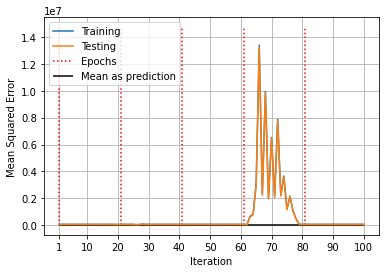

In [24]:
nn_plot_iter_mse(train_mse_dict["model_1"],
                 test_mse_dict["model_1"],
                 iteration_dict["model_1"],
                 mse_mean = mean_squared_error(y_test, np.ones(shape = (len(y_test),))*np.mean(y_test)))

## Jetzt mit der Jacobimatrix aus Tensorflow

In [25]:
model_dict = {}
weights_dict = {}
y_pred_dict = {}
jacobian_dict = {}
weights_vector_dict = {}
train_mse_dict = {}
test_mse_dict = {}
iteration_dict = {}

# init_model already has weights and biases following the Glorot distribution
# it can already be used to predict and evaluate, but it is very bad (<10% accuracy)
# only used to determine shapes and shape_elements via its weights
init_model = nn_model_structure(layers = layers,
                                neurons = neurons,
                                n_cols = n_cols,
                                classification = False)
init_model = nn_model_compile(init_model,
                              optimizer = "sgd")
weights = init_model.get_weights()
# shape contains the shapes of the weight matrices and bias vectors as a list of arrays
shapes = [np.array(params.shape) for params in weights]
# shape_elements contains the indices of the weights as a vector and tells where to cut
shape_elements = np.cumsum([0] + [np.prod(shape) for shape in shapes])

In [26]:
for i in range(particles):
    # just an initial model with the correct structure regarding neurons, layers, activation functions, Glorot initialization
    model = nn_model_structure(layers = layers,
                               neurons = neurons,
                               n_cols = n_cols,
                               classification = False)
    model = nn_model_compile(model,
                             optimizer = "sgd")
    # for every particle write the model in a dictionary
    model_dict["model_{}".format(str(i+1))] = model
    
    # for every particles write the weights and biases in a dictionary
    weights_dict["model_{}".format(str(i+1))] = model_dict["model_{}".format(str(i+1))]\
                                                    .get_weights()
    
    train_mse_dict["model_{}".format(str(i+1))] = []
    test_mse_dict["model_{}".format(str(i+1))] = []
    iteration_dict["model_{}".format(str(i+1))] = []

In [27]:
import tensorflow as tf

loss_fct = tf.keras.losses.MeanSquaredError(reduction = "none")

In [28]:
# loop over all epochs
for epoch in range(epochs):
    # shuffle the data
    if shuffle:
        indices = y_train.sample(frac=1).index
        X_batches = [np.array(X_train)[indices][int(batch_indices[i]):int(batch_indices[i+1])] for i in range(len(batch_indices)-1)]
        y_batches = [y_train.iloc[indices].reset_index(drop = True)[int(batch_indices[i]):int(batch_indices[i+1])] for i in range(len(batch_indices)-1)]
        y_batches = [np.array(i) for i in y_batches]
    # loop over all batches
    for b in range(num_batches):    
        for i in range(particles):
            # set new weights for model
            model_dict["model_{}".format(str(i+1))].set_weights(weights_dict["model_{}".format(str(i+1))])
            
            # for every particle write the predictions on the training batches in a dictionary
            y_pred_dict["model_{}".format(str(i+1))] = model_dict["model_{}".format(str(i+1))]\
                                                            .predict(X_batches[b])

            # for every particle write the Jacobian in a dictionary
            y_batch_tf = tf.constant(y_batches[b])
            y_pred_tf = tf.Variable(y_pred_dict["model_{}".format(str(i+1))])
            
            with tf.GradientTape() as tape:
                loss_value = loss_fct(y_batch_tf, y_pred_tf)
            jacobian_tf = tape.gradient(loss_value, y_pred_tf)
            
            jacobian_dict["model_{}".format(str(i+1))] = jacobian_tf.numpy()
            
            # for every particle write the training accuracy of the current iteration in a dictionary
            train_mse_dict["model_{}".format(str(i+1))].append(model_dict["model_{}".format(str(i+1))]\
                                                                      .evaluate(X_train, y_train, verbose = 0)[1])
            
            # for every particle write the test accuracy of the current iteration in a dictionary
            test_mse_dict["model_{}".format(str(i+1))].append(model_dict["model_{}".format(str(i+1))]\
                                                                      .evaluate(X_test, y_test, verbose = 0)[1])
            
            # for every particle write the current iteration in a dictionary
            iteration_dict["model_{}".format(str(i+1))].append("Epoch: {}, Batch: {}.".format(epoch+1, b+1))
            
        # compute the mean of the predictions
        y_pred_mean = np.mean(list(y_pred_dict.values()), axis = 0)
        
        # compute the matrix D elementwise
        d = np.zeros(shape = (particles, particles))
        for k in range(particles):
            y_pred_centered = y_pred_dict["model_{}".format(str(k+1))] - y_pred_mean
            for j in range(particles):
                d[k][j] = np.dot(y_pred_centered.ravel(), jacobian_dict["model_{}".format(str(j+1))])
                                       
        # compute the scalar h_t
        h_t = h_0 / (np.sqrt(np.sum(d**2)) + epsilon)
        
        # Reshape the weights and biases so that they are no longer matrices and vectores, but now one single vector
        for i in range(particles):
            weights_array = np.array([])
            for j in range(len(weights_dict["model_{}".format(str(i+1))])):
                weights_array = np.append(weights_array, np.reshape(weights_dict["model_{}".format(str(i+1))][j], (1, -1)).ravel())
            weights_vector_dict["model_{}".format(str(i+1))] = weights_array
          
        # matrix with particle parameters as row vectors
        weights_all_ptcls = np.array(list(weights_vector_dict.values()))

        # compute the matrix with the updates for each particle
        weights_all_ptcls = weights_all_ptcls - h_t * np.matmul(d, weights_all_ptcls)

        for i in range(particles):
            # write the updates back into the dictionary
            weights_vector_dict["model_{}".format(str(i+1))] = weights_all_ptcls[i]
            # reshape the updates, so that they are of the original matrx and vector shape
            for l in range(len(shape_elements)-1):
                start = shape_elements[l]
                end = shape_elements[l+1]
                weights_dict["model_{}".format(str(i+1))][l] = np.reshape(weights_vector_dict["model_{}".format(str(i+1))][start:end], tuple(shapes[l]))
            if randomization:
                # add randomization
                new_weights = []
                for s in range(len(shapes)):
                    if shapes[s].shape[0] == 2:
                        fan_in = shapes[s][0]
                        fan_out = shapes[s][1]
                    if shapes[s].shape[0] == 1:
                        fan_in = shapes[s-1][0]
                        fan_out = shapes[s][0]
                    stddev = np.sqrt(np.sqrt(h_t)) * np.sqrt(2 / (fan_in + fan_out))
                    noise = np.random.normal(loc = 0.0,
                                             scale = stddev,
                                             size = tuple(shapes[s]))
                    new_weights.append(weights_dict["model_{}".format(str(i+1))][s] + noise)
                weights_dict["model_{}".format(str(i+1))] = new_weights
    if randomization:
        weights_mean = list(np.mean(list(weights_dict.values()), axis = 0))
        for i in range(particles):
            new_weights = []
            for s in range(len(shapes)):
                if shapes[s].shape[0] == 2:
                    fan_in = shapes[s][0]
                    fan_out = shapes[s][1]
                if shapes[s].shape[0] == 1:
                    fan_in = shapes[s-1][0]
                    fan_out = shapes[s][0]
                stddev = np.sqrt(2 / (fan_in + fan_out))
                noise = np.random.normal(loc = 0.0,
                                         scale = stddev,
                                         size = tuple(shapes[s]))
                new_weights.append(weights_mean[s] + noise)
            weights_dict["model_{}".format(str(i+1))] = new_weights

In [29]:
mean_weights = list(np.mean(list(weights_dict.values()), axis = 0))
init_model.set_weights(mean_weights)

In [30]:
init_model.evaluate(X_test, y_test)

16/16 [==============================] - 0s 2ms/step - loss: 66232.1641 - mse: 66232.1641


[66232.1640625, 66232.1640625]

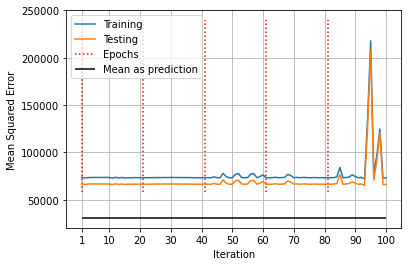

In [31]:
nn_plot_iter_mse(train_mse_dict["model_1"],
                 test_mse_dict["model_1"],
                 iteration_dict["model_1"],
                 mse_mean = mean_squared_error(y_test, np.ones(shape = (len(y_test),))*np.mean(y_test)))

## Jetzt mit dem ursprünglichen EnKF-Algorithmus wie für inverse Probleme

#### Problem: 
$C^{ww}$ ist singuläre Matrix und kann nicht invertiert werden. Mit der Pseudoinversen kommt der Error "SVD did not converge" und dieser Error für kleinere Gamma-Diagonalmatrizen später. Obwohl sich der MSE verringert, ist er dennoch mit $10^{23}$ viel zu groß, als dass das so Sinn ergeben würde.

#### scheinbar doch nicht immer...

In [32]:
model_dict = {}
weights_dict = {}
y_pred_dict = {}
jacobian_dict = {}
weights_vector_dict = {}
train_mse_dict = {}
test_mse_dict = {}
iteration_dict = {}

# init_model already has weights and biases following the Glorot distribution
# it can already be used to predict and evaluate, but it is very bad (<10% accuracy)
# only used to determine shapes and shape_elements via its weights
init_model = nn_model_structure(layers = layers,
                                neurons = neurons,
                                n_cols = n_cols,
                                classification = False)
init_model = nn_model_compile(init_model,
                              optimizer = "sgd")
weights = init_model.get_weights()
# shape contains the shapes of the weight matrices and bias vectors as a list of arrays
shapes = [np.array(params.shape) for params in weights]
# shape_elements contains the indices of the weights as a vector and tells where to cut
shape_elements = np.cumsum([0] + [np.prod(shape) for shape in shapes])

In [33]:
for i in range(particles):
    # just an initial model with the correct structure regarding neurons, layers, activation functions, Glorot initialization
    model = nn_model_structure(layers = layers,
                               neurons = neurons,
                               n_cols = n_cols,
                               classification = False)
    model = nn_model_compile(model,
                             optimizer = "sgd")
    # for every particle write the model in a dictionary
    model_dict["model_{}".format(str(i+1))] = model
    
    # for every particles write the weights and biases in a dictionary
    weights_dict["model_{}".format(str(i+1))] = model_dict["model_{}".format(str(i+1))]\
                                                    .get_weights()
    
    train_mse_dict["model_{}".format(str(i+1))] = []
    test_mse_dict["model_{}".format(str(i+1))] = []
    iteration_dict["model_{}".format(str(i+1))] = []

In [34]:
# loop over all epochs
for epoch in range(epochs):
    # shuffle the data
    if shuffle:
        indices = y_train.sample(frac=1).index
        X_batches = [np.array(X_train)[indices][int(batch_indices[i]):int(batch_indices[i+1])] for i in range(len(batch_indices)-1)]
        y_batches = [y_train.iloc[indices].reset_index(drop = True)[int(batch_indices[i]):int(batch_indices[i+1])] for i in range(len(batch_indices)-1)]
        y_batches = [np.array(i) for i in y_batches]
    # loop over all batches
    for b in range(num_batches):    
        for i in range(particles):
            # set new weights for model
            model_dict["model_{}".format(str(i+1))].set_weights(weights_dict["model_{}".format(str(i+1))])
            
            # for every particle write the predictions on the training batches in a dictionary
            y_pred_dict["model_{}".format(str(i+1))] = model_dict["model_{}".format(str(i+1))]\
                                                            .predict(X_batches[b])

            # for every particle write the training accuracy of the current iteration in a dictionary
            train_mse_dict["model_{}".format(str(i+1))].append(model_dict["model_{}".format(str(i+1))]\
                                                                      .evaluate(X_train, y_train, verbose = 0)[1])
            
            # for every particle write the test accuracy of the current iteration in a dictionary
            test_mse_dict["model_{}".format(str(i+1))].append(model_dict["model_{}".format(str(i+1))]\
                                                                      .evaluate(X_test, y_test, verbose = 0)[1])
            
            # for every particle write the current iteration in a dictionary
            iteration_dict["model_{}".format(str(i+1))].append("Epoch: {}, Batch: {}.".format(epoch+1, b+1))
            
        # compute the mean of the parameters
        weights_mean = np.mean(list(weights_dict.values()), axis = 0)
        mean_array = np.array([])
        for i in range(weights_mean.shape[0]):
            mean_array = np.append(mean_array, np.reshape(weights_mean[i], (1, -1)))
            
        # compute the mean of the predictions
        y_pred_mean = np.mean(list(y_pred_dict.values()), axis = 0)
                                       
        # Reshape the weights and biases so that they are no longer matrices and vectores, but now one single vector
        for i in range(particles):
            weights_array = np.array([])
            for j in range(len(weights_dict["model_{}".format(str(i+1))])):
                weights_array = np.append(weights_array, np.reshape(weights_dict["model_{}".format(str(i+1))][j], (1, -1)).ravel())
            weights_vector_dict["model_{}".format(str(i+1))] = weights_array
            
        # compute the 
        weight_diff_dict = {}
        pred_diff_theta_dict = {}
        pred_diff_w_dict = {}
        c_theta_w_dict = {}
        c_w_w_dict = {}
        for i in range(particles):
            weight_diff_dict["model_{}".format(str(i+1))] = weights_vector_dict["model_{}".format(str(i+1))] - mean_array
            pred_diff_theta_dict["model_{}".format(str(i+1))] = y_pred_dict["model_{}".format(str(i+1))] - y_pred_mean
            pred_diff_w_dict["model_{}".format(str(i+1))] = y_pred_dict["model_{}".format(str(i+1))] - y_pred_mean
        for i in range(particles):
            weight_diff_dict["model_{}".format(str(i+1))] = np.transpose(np.tile(weight_diff_dict["model_{}".format(str(i+1))], (pred_diff_theta_dict["model_{}".format(str(i+1))].shape[0], 1)))
            pred_diff_theta_dict["model_{}".format(str(i+1))] = np.transpose(np.tile(pred_diff_theta_dict["model_{}".format(str(i+1))], (1, weight_diff_dict["model_{}".format(str(i+1))].shape[0])))
            pred_diff_w_dict["model_{}".format(str(i+1))] = np.transpose(np.tile(pred_diff_w_dict["model_{}".format(str(i+1))], (1, pred_diff_w_dict["model_{}".format(str(i+1))].shape[0])))
            c_theta_w_dict["model_{}".format(str(i+1))] = np.multiply(weight_diff_dict["model_{}".format(str(i+1))], pred_diff_theta_dict["model_{}".format(str(i+1))])
            c_w_w_dict["model_{}".format(str(i+1))] = np.multiply(pred_diff_w_dict["model_{}".format(str(i+1))], pred_diff_w_dict["model_{}".format(str(i+1))])
        c_theta_w = np.mean(list(c_theta_w_dict.values()), axis = 0)
        c_w_w = np.mean(list(c_w_w_dict.values()), axis = 0)
          
        # matrix with particle parameters as row vectors
        # weights_all_ptcls = np.array(list(weights_vector_dict.values()))
        for i in range(particles):
            print(i)
        # compute the matrix with the updates for each particle
            weights_vector_dict["model_{}".format(str(i+1))] = weights_vector_dict["model_{}".format(str(i+1))] + np.dot(np.dot(c_theta_w, np.linalg.pinv(c_w_w + np.diag(np.ones(c_w_w.shape[0])*0.5))), y_batches[b] - y_pred_dict["model_{}".format(str(i+1))].ravel())
            
        for i in range(particles):
            # write the updates back into the dictionary
            # weights_vector_dict["model_{}".format(str(i+1))] = weights_all_ptcls[i]
            # reshape the updates, so that they are of the original matrx and vector shape
            for l in range(len(shape_elements)-1):
                start = shape_elements[l]
                end = shape_elements[l+1]
                weights_dict["model_{}".format(str(i+1))][l] = np.reshape(weights_vector_dict["model_{}".format(str(i+1))][start:end], tuple(shapes[l]))

0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9


In [35]:
train_mse_dict

{'model_1': [72785.7265625,
  1.2007360417066544e+24,
  8.034254561610797e+23,
  6.794577154934165e+23,
  6.260462488919011e+23,
  5.4263774632435155e+23,
  5.372956124751617e+23,
  5.163664122292515e+23,
  5.106547310090381e+23,
  4.6908805568668024e+23,
  4.6260085461063367e+23,
  4.541294035675647e+23,
  4.338226368189541e+23,
  4.272315286923048e+23,
  4.295684645533459e+23,
  4.246321590737776e+23,
  4.231141217401806e+23,
  4.120164596248053e+23,
  4.108161242233215e+23,
  3.972546328238043e+23,
  3.9867708575891e+23,
  3.96782871755638e+23,
  3.967477076497475e+23,
  3.884819089800627e+23,
  3.883123574612915e+23,
  3.864114421017739e+23,
  3.841124085351968e+23,
  3.734041816867995e+23,
  3.7200734522637424e+23,
  3.7564120969370695e+23,
  3.771942670180064e+23,
  3.806994366223874e+23,
  3.7529183844901405e+23,
  3.644911977362631e+23,
  3.66943786035735e+23,
  3.7478570590849165e+23,
  3.683900900344673e+23,
  3.6615673696485574e+23,
  3.6600321826075793e+23,
  3.595078746765

In [36]:
mean_weights = list(np.mean(list(weights_dict.values()), axis = 0))
init_model.set_weights(mean_weights)

In [37]:
init_model.evaluate(X_test, y_test)

16/16 [==============================] - 0s 2ms/step - loss: 302964100491037925965824.0000 - mse: 302964100491037925965824.0000


[3.029641004910379e+23, 3.029641004910379e+23]